In [1]:
import cv2
import easyocr
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
display.clear_output()
from IPython.display import display, Image
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import functools
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import easyocr

Ultralytics YOLOv8.0.117 🚀 Python-3.9.13 torch-2.0.1+cu117 CPU
Setup complete ✅ (4 CPUs, 3.7 GB RAM, 90.6/233.2 GB disk)


In [2]:
def preprocess_image(image):
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Display the grayscale image
    display(Image(data=cv2.imencode('.jpg',grayscale_image)[1].tobytes()))
    #gaussian blur
    blur= cv2.GaussianBlur(grayscale_image,(5,5),0)
     # Display the grayscale image
    display(Image(data=cv2.imencode('.jpg',blur)[1].tobytes()))
    
    return blur

In [24]:
def threshold(image):
    # Apply Otsu thresholding
    _, threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the colors
    inverted_image = cv2.bitwise_not(threshold_image)
    
    # Display the threshold image
    display(Image(data=cv2.imencode('.jpg',inverted_image)[1].tobytes()))
    return inverted_image  

In [25]:
def segment_characters(image):
    # Perform connected components analysis on the thresholded image and
    # initialize the mask to hold only the components we are interested in
    _, labels = cv2.connectedComponents(image)
    mask = np.zeros(image.shape, dtype="uint8")
    
    # Set lower bound and upper bound criteria for characters
    total_pixels = image.shape[0] * image.shape[1]
    lower = total_pixels // 100 # heuristic param, can be fine tuned if necessary
    upper = total_pixels // 10 # heuristic param, can be fine tuned if necessary

    # Loop over the unique components
    for (i, label) in enumerate(np.unique(labels)):
        # If this is the background label, ignore it
        if label == 255:
            continue

        # Otherwise, construct the label mask to display only connected component
        # for the current label
        labelMask = np.zeros(image.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        # If the number of pixels in the component is between lower bound and upper bound, 
        # add it to our mask
        if numPixels > lower and numPixels < upper:
            mask = cv2.add(mask, labelMask)
            
    display(Image(data=cv2.imencode('.jpg',mask)[1].tobytes()))
    return mask



In [26]:
def recognize_number_plate(image_path,  scale_factor=3):
    vehicle_image = cv2.imread(image_path)
    model = YOLO('best.pt') 
    model.conf = 0.4  #confidence threshold for detection
    # Perform object detection using YOLO
    detections = model(vehicle_image)


    # Extract bounding boxes and crop number plate regions
    number_plate_box = None
    for detection in detections[0].boxes.data:
        if detection[5] == 0:  
            number_plate_box = detection[:4]
            break  
            
#      Draw bounding box on the original image
    if number_plate_box is not None:
        x1, y1, x2, y2 = number_plate_box
        cv2.rectangle(vehicle_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    # Display the original image with bounding box
    display(Image(data=cv2.imencode('.jpg', vehicle_image)[1].tobytes()))
    
    # Crop and Preprocess the number plate region
    if number_plate_box is not None:
        # Crop the number plate region
        cropped_image = vehicle_image[int(y1):int(y2), int(x1):int(x2)]
        # Display the cropped image
        display(Image(data=cv2.imencode('.jpg', cropped_image)[1].tobytes()))
        
         # Scale the cropped image
        scaled_image = cv2.resize(cropped_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
        # Display the scaled image
        display(Image(data=cv2.imencode('.jpg', scaled_image)[1].tobytes()))
        
        preprocess= preprocess_image(scaled_image)
        threshold_image= threshold(preprocess)
        segment_image= segment_characters(threshold_image)
        
    return segment_image



0: 608x800 1 License-plate, 468.0ms
Speed: 6.9ms preprocess, 468.0ms inference, 1.0ms postprocess per image at shape (1, 3, 800, 800)


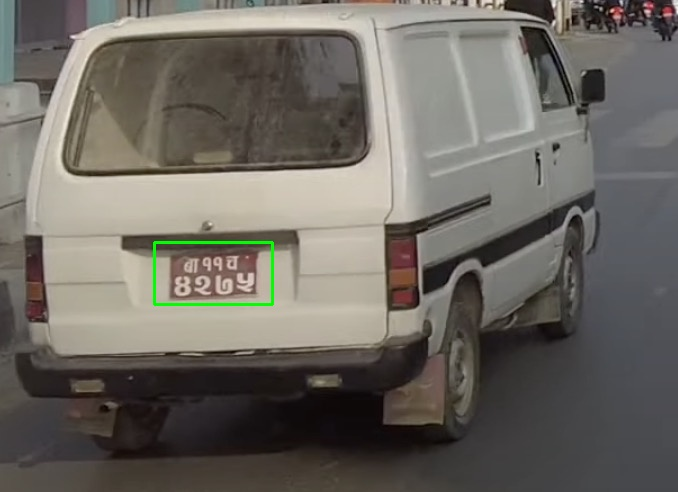

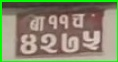

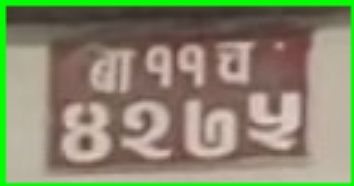

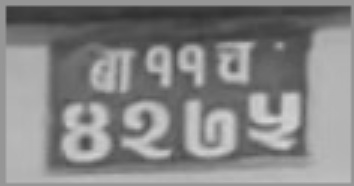

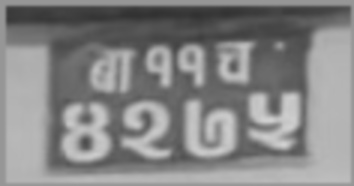

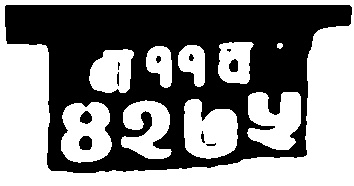

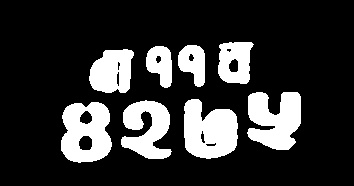

In [27]:
image_path = '108.jpg'
Image(image_path)
# Recognize the number plate
mask = recognize_number_plate(image_path)

In [45]:
# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    
    # Sort the bounding boxes from left to right, top to bottom
    # sort by Y first, and then sort by X if Ys are similar
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )

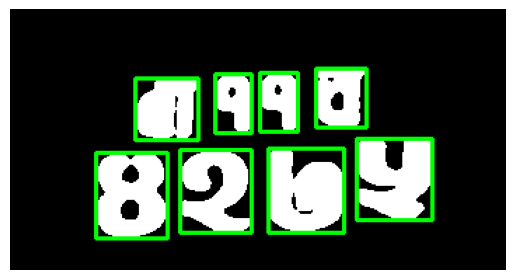

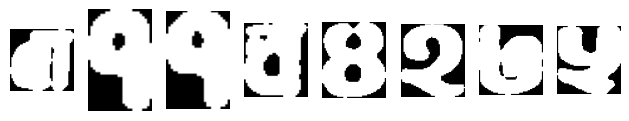

In [46]:

# Draw bounding boxes on the mask image
mask_with_boxes = cv2.cvtColor(mask.copy(), cv2.COLOR_GRAY2BGR)  # Convert mask to BGR color space
segmented_characters = []

for (x, y, w, h) in boundingBoxes:
    # Extract the segmented character region from the mask
    segmented_character = mask[y:y+h, x:x+w]
    
    # Add the segmented character to the list
    segmented_characters.append(segmented_character)
    
    # Draw the bounding box on the mask image
    cv2.rectangle(mask_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the mask image with bounding boxes using Matplotlib
plt.imshow(mask_with_boxes)
plt.axis('off')
plt.show()

# # Access the segmented characters from the list
# for i, character in enumerate(segmented_characters):
#     # Perform operations or analysis on the segmented character
#     # For example, display the segmented character using IPython display
#     display(Image(data=cv2.imencode('.jpg', character)[1].tobytes()))

# Create a figure with subplots arranged horizontally
fig, axes = plt.subplots(1, len(segmented_characters))

# Iterate over segmented characters and display them in subplots
for i, character in enumerate(segmented_characters):
    # Display the segmented character in the corresponding subplot
    axes[i].imshow(character, cmap='gray')
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with all the segmented characters
plt.show()


In [53]:
# # Load the saved model
# model = load_model('cnnmodel.h5')


In [57]:
# import cv2
# from keras.preprocessing import image
# import numpy as np

# Plate = ''

# # Iterate over the segmented characters and resize each one
# for character in segmented_characters:
#     resized_image = cv2.resize(character, (28, 28))
    
# #     # Check if the image is already grayscale
# #     if resized_image.shape[-1] == 1:
# #         grayscale_image = resized_image
# #     else:
# #         # Convert the image to grayscale
# #         grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
#     # Duplicate the grayscale channel to match 3 channels (RGB)
#     rgb_image = np.stack([resized_image] * 3, axis=2)
    
#     # Reshape the image array to match the expected input shape of the model
#     reshaped_image = rgb_image.reshape((1, 28, 28, 3))
    
#     # Normalize the image
#     reshaped_image = reshaped_image.astype('float32') / 255.0

#     # Perform prediction on the character
#     predictions = model.predict(reshaped_image)
#     predicted_label = np.argmax(predictions)  # Get the index of the maximum prediction

#     if predicted_label < 10:
#         Plate += str(predicted_label)  # Return digit as a string
#     elif predicted_label == 10:
#         Plate += "ba"
#     elif predicted_label == 11:
#         Plate += "cha"
#     elif predicted_label == 12:
#         Plate += "pa"
#     else:
#         Plate += "Unknown"

# print("plate:", Plate)


1/1 [==============================] - 0s 30ms/step
plate: 31133538


In [49]:
# Load the saved model
model_1 = load_model('model.h5')

In [51]:
def predict_character(image, model):
    # Resize and preprocess the image
    image = cv2.resize(image, (50, 50))
    image = image.reshape(-1, image.shape[0], 50, 1)

    # Predict using the CNN model
    classes = model.predict(image)
    classes = np.argmax(classes)  # Get the index of the maximum prediction

    return classes


In [52]:
Plate = ' '

for character in segmented_characters:
    cnn_prediction = predict_character(character, model_1)

    if cnn_prediction < 10:
        Plate += str(cnn_prediction)
    elif cnn_prediction == 10:
        Plate += 'BA '
    elif cnn_prediction == 11:
        Plate += ' CHA '
    elif cnn_prediction == 12:
        Plate += ' PA '
    else:
        Plate += 'Unknown'



print('Plate:', Plate)




1/1 [==============================] - 0s 38ms/step
Plate:  BA 11 CHA 4275
